In [1]:
# Add folder to path in order to load from the check_packages.py script
import sys
sys.path.insert(0, "..")

In [2]:
import os
import json
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from imblearn.over_sampling import BorderlineSMOTE

In [3]:
print(os.getcwd())
# Going up one directory from current (notebooks) to the project root
os.chdir("..")
print(os.getcwd())

C:\Users\Nene\iot_sensors_prediction_classification\notebooks
C:\Users\Nene\iot_sensors_prediction_classification


In [61]:
with open("config.json", "r") as file:
    config = json.load(file)

In [67]:
# Utility functions
def load_data(path):
    data = {}
    
    for folder in os.listdir(path):
        if folder == "Not using":
            continue
            
        if folder == "clean":
            cur_folder = pathlib.Path(os.path.join(path, folder))
            all_files_path = list(cur_folder.glob("*.txt"))
            dfs = [] 
            for file_path in all_files_path:
                try:
                    df = pd.read_csv(file_path, sep=None, engine="python")
                    dfs.append(df)
                except Exception as e:
                    print(f" Error reading '{file_path}': {e}")
            if dfs:
                data[folder]= pd.concat(dfs, ignore_index=True)
        
        else:
            cur_folder = pathlib.Path(os.path.join(path, folder))
            if not os.path.exists(cur_folder):
                print(f" Skipping '{cur_folder}' (Not found)")
                continue

            all_files_path = list(cur_folder.glob("*.txt"))
            temp_files = [file for file in all_files_path if "sensortype=temperature" in file.name]
            dfs = [] 
            for file_path in temp_files:
                try:
                    df = pd.read_csv(file_path, sep=None, engine="python")
                    dfs.append(df)
                except Exception as e:
                    print(f" Error reading '{file_path}': {e}")
            if dfs:
                data[folder]= pd.concat(dfs, ignore_index=True)

    return data


def merge_data(dataset):
    conditions = list(dataset.keys())
    combined_df = pd.concat([dataset[cond] for cond in conditions], ignore_index=True)


    return combined_df


def create_sequence(df, group_by, window_size=6, horizon=4):
    X_encoder_num = []
    X_encoder_cat = []

    X_decoder_input_num = []
    X_decoder_input_cat = [] 

    y_decoder_output = []

    for mote in df[group_by].unique():
        mote_df = df[df[group_by] == mote].copy()

        data_array = mote_df.values

        for i in range(len(data_array) - window_size - horizon + 1):
            encoder_seq = data_array[i : i + window_size]
            X_encoder_num.append(encoder_seq[:, 0])
            X_encoder_cat.append(encoder_seq[:, 1:])

            decoder_input_temp_seq = []
            decoder_input_cat_seq = []
            target_seq = []

            for j in range(horizon):
                if j == 0:
                    lagged_temp = data_array[i + window_size-1, 0]
                else:
                    lagged_temp = data_array[i + window_size + j - 1, 0]

                # categorical features for future values:
                future_cat_features = data_array[i + window_size + j, 1:]

                decoder_input_temp_seq.append(lagged_temp)
                decoder_input_cat_seq.append(future_cat_features)

                target_step = data_array[i + window_size + j, 0]
                target_seq.append(target_step)

            X_decoder_input_num.append(np.array(decoder_input_temp_seq))
            X_decoder_input_cat.append(np.array(decoder_input_cat_seq))
            y_decoder_output.append(np.array(target_seq))
            
    X_encoder_num = np.array(X_encoder_num).reshape(-1, window_size, 1)
    X_encoder_cat = np.array(X_encoder_cat).reshape(-1, window_size, 1) 
    X_decoder_input_num = np.array(X_decoder_input_num).reshape(-1, horizon, 1)
    X_decoder_input_cat = np.array(X_decoder_input_cat).reshape(-1, horizon, 1)
    y_decoder_output = np.array(y_decoder_output).reshape(-1, horizon, 1)
            
    return X_encoder_num, X_encoder_cat, X_decoder_input_num, X_decoder_input_cat, y_decoder_output



# EDA, Preprocessing and Feature Engineering for the CNN-LSTM System Data

In [18]:
data = load_data(config["inter_data_path"])

In [19]:
all_data = merge_data(data)

In [20]:
len(all_data)

1008000

In [21]:
all_data.head()

,timestamp,mote_id,has_fault_type,temperature,light
0,'2004-02-29T00:00:00',1,0,19.2600,45.08
1,'2004-02-29T00:00:30',1,0,19.2500,45.08
2,'2004-02-29T00:01:00',1,0,19.2500,45.08
3,'2004-02-29T00:01:30',1,0,19.2436,45.08
4,'2004-02-29T00:02:00',1,0,19.2400,45.08


In [19]:
start_date, end_date = all_data["timestamp"].min(), all_data["timestamp"].max()
print("Start Date:", start_date)
print("End Date:", end_date)
print("Time period:", end_date - start_date )

# we have 6days 23h+(aprox 7days) what of data, spaced at 30 seconds

Start Date: 2004-02-29 00:00:00
End Date: 2004-03-06 23:59:30
Time period: 6 days 23:59:30


In [22]:
all_data.mote_id.value_counts()

1     100800
4     100800
6     100800
19    100800
22    100800
23    100800
29    100800
33    100800
34    100800
45    100800
Name: mote_id, dtype: int64

In [23]:
# Removes leading and trailing whitespace, double quotes, single quotes
all_data["timestamp"] = all_data["timestamp"].str.strip().str.replace('"', '').str.replace("'", '')

# convert 'timestamp' to datetime
all_data["timestamp"] = pd.to_datetime(all_data.timestamp, format="%Y-%m-%dT%H:%M:%S")

In [38]:
# # Temperatures plot for each sensors to see the multi_time_series trend
# fig = plt.figure(figsize=(12, 8))
# mote_ids = all_data.mote_id.unique()
# for m_id in mote_ids:
#     sensor_data = all_data[all_data["mote_id"] == m_id]
#     plt.plot(sensor_data["timestamp"], sensor_data["temperature"], label=str(m_id))

# plt.legend(loc="best")         
# plt.ylabel("Temperature")         
# plt.xlabel("Date")                
# plt.title("Temperature Over Time for Each Sensor")
# plt.tight_layout()
# plt.show()

In [26]:
all_data["hour_of_day"] = all_data["timestamp"].dt.hour

In [28]:
# Create an intereaction feature between mote_id and fault_type
all_data["mote_fault"] = all_data["mote_id"].astype(str) + "_" + all_data["has_fault_type"].astype(str)
all_data["mote_fault"] = all_data["mote_fault"].astype(int)

In [31]:
# all_data.mote_fault.unique()
all_data.mote_fault.nunique()

50

In [35]:
all_data.head()

,timestamp,mote_id,has_fault_type,temperature,light,hour_of_day,mote_fault
0,2004-02-29 00:00:00,1,0,19.2600,45.08,0,1_0
1,2004-02-29 00:00:30,1,0,19.2500,45.08,0,1_0
2,2004-02-29 00:01:00,1,0,19.2500,45.08,0,1_0
3,2004-02-29 00:01:30,1,0,19.2436,45.08,0,1_0
4,2004-02-29 00:02:00,1,0,19.2400,45.08,0,1_0


In [39]:
# Cyclic feature encoding
hours_in_a_day = 24
all_data["hour_sin"] = np.sin(2*np.pi* all_data.hour_of_day/hours_in_a_day)
all_data["hour_cos"] = np.cos(2*np.pi* all_data.hour_of_day/hours_in_a_day)

Text(0.5, 1.0, 'Hour Encoding (Sin vs Cos)')

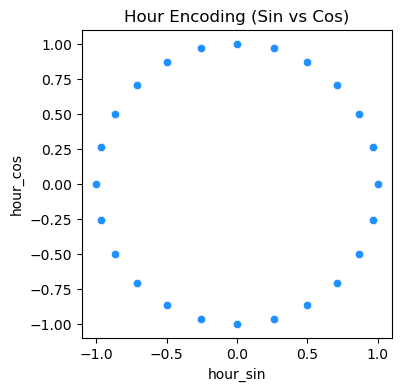

In [42]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(x=all_data.hour_sin, y=all_data.hour_cos, color="dodgerblue")
plt.title("Hour Encoding (Sin vs Cos)")

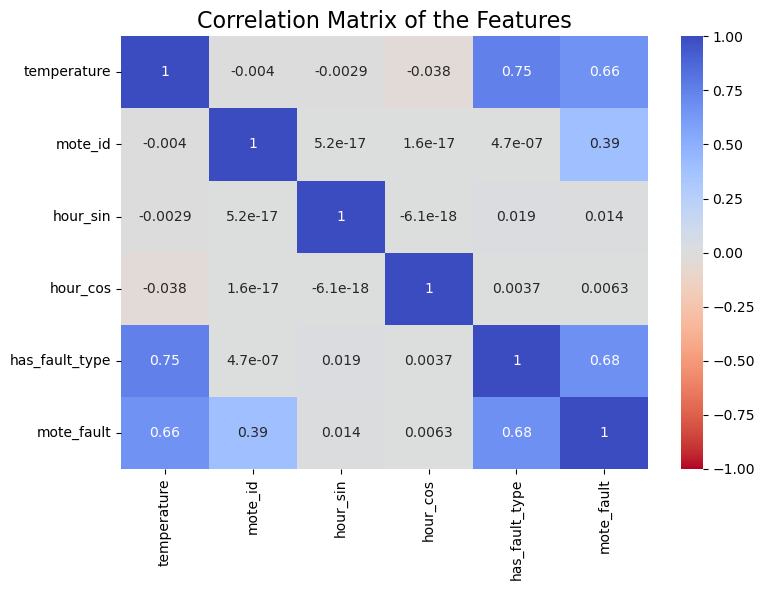

In [50]:
# correlation matrix
f, ax = plt.subplots(figsize=(8, 6))

columns = ["temperature", "mote_id", "hour_sin","hour_cos", 
         "has_fault_type","mote_fault"]

corrmat = all_data[columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap="coolwarm_r", ax=ax)
ax.set_title("Correlation Matrix of the Features", fontsize=16)


plt.tight_layout()
plt.show()

In [51]:
target = "temperature"
corrmat_sorted = corrmat[[target]].sort_values(by=target, ascending=False)
print(corrmat_sorted)

                temperature
temperature        1.000000
has_fault_type     0.753056
mote_fault         0.661294
hour_sin          -0.002912
mote_id           -0.003999
hour_cos          -0.038174


In [52]:
# Categorical Feature Encoding using LabelEncoder
le_mote_id = LabelEncoder()
le_fault_type = LabelEncoder()
le_mote_fault = LabelEncoder()

all_data["mote_id_encoded"] = le_mote_id.fit_transform(all_data["mote_id"])
all_data["fault_type_encoded"] = le_fault_type.fit_transform(all_data["has_fault_type"])
all_data["mote_fault_encoded"] = le_mote_fault.fit_transform(all_data["mote_fault"])

In [56]:
all_data.sample(7)

,timestamp,mote_id,has_fault_type,temperature,light,hour_of_day,mote_fault,hour_sin,hour_cos,mote_id_encoded,fault_type_encoded,mote_fault_encoded
791688,2004-03-01 21:24:00,6,0,20.4390,20.24,21,60,-0.707107,0.707107,2,0,8
578747,2004-03-04 22:53:30,4,8,-21.9110,101.20,22,48,-0.500000,0.866025,1,3,7
697648,2004-03-04 05:44:00,29,0,17.7340,0.46,5,290,0.965926,0.258819,6,0,25
592299,2004-03-02 15:49:30,6,0,22.4090,566.72,15,60,-0.707107,-0.707107,2,0,8
495420,2004-03-04 00:30:00,29,0,19.9880,23.00,0,290,0.000000,1.000000,6,0,25
134821,2004-03-04 19:30:30,29,0,22.1500,187.68,19,290,-0.965926,0.258819,6,0,25
181304,2004-03-06 22:52:00,34,0,21.2526,64.40,22,340,-0.500000,0.866025,8,0,33


## Feature Selection & Preparation

In [58]:
scaler_temp = MinMaxScaler(feature_range=(-1,1))
all_data["temperature_scaled"] = scaler_temp.fit_transform(all_data[["temperature"]])

In [60]:
selected_features = ["temperature_scaled","mote_id_encoded"]
pred_data = all_data[selected_features]

In [68]:
# Turning the dataset into sequence array appropriate for time-forecasting
window_size = config["window_size"]
horizon = config["forecast_horizon"]
X_encoder_num, X_encoder_cat, X_decoder_input_num,X_decoder_input_cat, y_decoder_output = create_sequence(pred_data,"mote_id_encoded", window_size, horizon)


In [69]:
print("Shape of X_encoder_numerical:", X_encoder_num.shape)
print("Shape of X_encoder_categorical:", X_encoder_cat.shape)
print("Shape of X_decoder_input_numerical (lagged temp):", X_decoder_input_num.shape)
print("Shape of X_decoder_input_categorical:", X_decoder_input_cat.shape)
print("Shape of y_decoder_output:", y_decoder_output.shape)

Shape of X_encoder_numerical: (1007890, 8, 1)
Shape of X_encoder_categorical: (1007890, 8, 3)
Shape of X_decoder_input_numerical (lagged temp): (1007890, 4, 1)
Shape of X_decoder_input_categorical: (1007890, 4, 3)
Shape of y_decoder_output: (1007890, 4, 1)


In [ ]:
split_idx_train = int(len(X_encode_num) * 0.8)
split_idx_val = int(len(X_encode_num) * 0.9)

X_enc_tem_train, X_enc_cat_train, X_dec_tem_train, X_dec_cat_train, y_dec_train = \
                        X_encoder_num[:split_idx_train], X_encoder_cat[:split_idx_train], \
                        X_decoder_input_num[:split_idx_train],X_decoder_input_cat[:split_idx_train], \
                        y_decoder_output[:split_idx_train]

X_enc_tem_valid, X_enc_cat_valid, X_dec_tem_valid, X_dec_cat_valid, y_dec_valid = \
                       X_encoder_num[split_idx_train:split_idx_val], X_encoder_cat[split_idx_train:split_idx_val], \
                       X_decoder_input_num[split_idx_train:split_idx_val],X_decoder_input_cat[split_idx_train:split_idx_val], \
                       y_decoder_output[split_idx_train:split_idx_val]

X_enc_tem_test, X_enc_cat_test, X_dec_tem_test, X_dec_cat_test, y_dec_test  = \
                    X_encoder_num[split_idx_val:], X_encoder_cat[split_idx_val:], \
                    X_decoder_input_num[split_idx_val:],X_decoder_input_cat[split_idx_val:], \
                    y_decoder_output[split_idx_val:]



In [ ]:
# saving
np.save(config["X_enc_tem_train_path"], X_enc_tem_train)
np.save(config["X_enc_cat_train_path"], X_enc_cat_train)
np.save(config["X_dec_tem_train_path"], X_dec_tem_train)
np.save(config["X_dec_cat_train_path"], X_dec_cat_train)
np.save(config["y_dec_train_path"], y_dec_train)

np.save(config["X_enc_tem_valid_path"], X_enc_tem_valid)
np.save(config["X_enc_cat_valid_path"], X_enc_cat_valid)
np.save(config["X_dec_tem_valid_path"], X_dec_tem_valid)
np.save(config["X_dec_cat_valid_path"], X_dec_cat_valid)
np.save(config["y_dec_valid_path"], y_dec_valid)

np.save(config["X_enc_tem_test_path"], X_enc_tem_test)
np.save(config["X_enc_cat_test_path"], X_enc_cat_test)
np.save(config["X_dec_tem_test_path"], X_dec_tem_test)
np.save(config["X_dec_cat_test_path"], X_dec_cat_test)
np.save(config["y_dec_test_path"], y_dec_test)

# EDA, Preprocessing and Feature Engineering for the CNN-MLP System Data

In [ ]:
merged_data = merge_dataset(data)
merged_data.shape[0]

In [ ]:
merged_data.head()

In [ ]:
cls_data = merged_data.drop(["timestamp", "mote_id", "light"], axis=1)

In [ ]:
cls_data.isna().sum()

In [ ]:
print(cls_data.duplicated().sum())
cls_data[cls_data.duplicated()].head(10)

In [ ]:
cls_data["has_fault_type"].unique()
# 0 ==> no fault, 4 ==> bias, 8 ==> drift, 16 ==> poly drift,  1 ==> random

In [ ]:
# re-numbering the 'has_fault_type' column
mapping = {0: 0, 1: 1, 4: 2, 8: 3, 16: 4}
cls_data["has_fault_type"] = cls_data["has_fault_type"].map(mapping)

In [ ]:
cls_data["has_fault_type"].unique()
# 0 ==> no fault, 2 ==> bias, 3 ==> drift, 4 ==> poly drift,  1 ==> random

In [ ]:
cls_data["has_fault_type"].value_counts()

In [ ]:
cls_data["has_fault_type"].value_counts(normalize=True)

As seen above, the "*no fault*" class contribules to more that 80% of the data. SMOTE techqune is applied to balance the data

In [ ]:
X = cls_data["temperature"].values.reshape(-1, 1)
y = cls_data["has_fault_type"]
y = y.astype(int)

In [ ]:
y.dtype

In [ ]:
# SMOTE
blsmote = BorderlineSMOTE(sampling_strategy="not majority", kind="borderline-1", random_state=42)
X_resampled, y_resampled = blsmote.fit_resample(X, y)
y_resampled.value_counts()

In [ ]:
# split to train, val, test
# convert this to a numpy array
y_resampled= y_resampled.values

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size= 0.3,
                                                   stratify=y_resampled, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42 )

In [ ]:
# standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [ ]:
total = len(X_resampled)
print(f"Train: {len(X_train)/total:.2f}")
print(f"Val:   {len(X_val)/total:.2f}")
print(f"Test:  {len(X_test)/total:.2f}")

In [ ]:
# saving
np.save(config["cls_X_train_path"], X_train)
np.save(config["cls_y_train_path"], y_train)

np.save(config["cls_X_val_path"], X_val)
np.save(config["cls_y_val_path"], y_val)

np.save(config["cls_X_test_path"], X_test)
np.save(config["cls_y_test_path"], y_test)

Done, for now